## Imports & chargement

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

# Afficher matplotlib inline si dans notebook
%matplotlib inline

# Charger les données (assure-toi que 'clean_data.csv' est dans le même dossier)
full_df = pd.read_csv('cic_ids2017_cleaned.csv')
# sample_df is provided by you; we won't overwrite it
try:
    sample_df = pd.read_csv('cic_ids2017_sample.csv')
except FileNotFoundError:
    sample_df = full_df.sample(min(500, len(full_df)))

print('Loaded', len(full_df), 'rows')
full_df.head()

Loaded 225741 rows


,timestamp,source_ip,destination_ip,attack_type,is_attack,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Fwd IAT Mean,Bwd IAT Mean
0,2025-10-31 16:02:14.096475,192.168.1.39,10.0.0.2,BENIGN,False,54865,3.0,2,0,12,0,4.000000e+06,666666.66670,3.0,3.0,0.0
1,2025-10-31 16:02:15.096475,192.168.1.29,10.0.0.17,BENIGN,False,55054,109.0,1,1,6,6,1.100917e+05,18348.62385,109.0,0.0,0.0
2,2025-10-31 16:02:16.096475,192.168.1.15,10.0.0.18,BENIGN,False,55055,52.0,1,1,6,6,2.307692e+05,38461.53846,52.0,0.0,0.0
3,2025-10-31 16:02:17.096475,192.168.1.43,10.0.0.18,BENIGN,False,46236,34.0,1,1,6,6,3.529412e+05,58823.52941,34.0,0.0,0.0
4,2025-10-31 16:02:18.096475,192.168.1.8,10.0.0.19,BENIGN,False,54863,3.0,2,0,12,0,4.000000e+06,666666.66670,3.0,3.0,0.0


In [6]:
full_df['attack_type'].value_counts()


,count
attack_type,
BENIGN,97714
DDoS,85352
Malware,8535
BruteForce,8535
WebAttack,8535
PortScan,8535
Botnet,8535


## Nettoyage rapide & champs temporels

In [10]:
# Nettoyage minimal : timestamps et colonnes clés
full_df['timestamp'] = pd.to_datetime(full_df['timestamp'], errors='coerce')
full_df = full_df.dropna(subset=['timestamp', 'source_ip', 'attack_type'])
full_df['date'] = full_df['timestamp'].dt.date
full_df['hour'] = full_df['timestamp'].dt.hour
full_df['dayofweek'] = full_df['timestamp'].dt.day_name()

# Vérif rapide des types d'attaque présents
print("Attack types:\n", full_df['attack_type'].value_counts())


Attack types:
 attack_type
BENIGN        97714
DDoS          85352
Malware        8535
BruteForce     8535
WebAttack      8535
PortScan       8535
Botnet         8535
Name: count, dtype: int64


## KPIs SOC (calculés)

In [11]:
# KPIs de base
metrics = {}
metrics['total_events'] = int(len(full_df))
metrics['total_benign'] = int((full_df['attack_type'] == 'BENIGN').sum())
metrics['total_attacks'] = int(metrics['total_events'] - metrics['total_benign'])
metrics['attack_rate_pct'] = float(metrics['total_attacks'] / metrics['total_events'] * 100)

# Détail par type
metrics['by_attack_type'] = full_df['attack_type'].value_counts().to_dict()

# Top 10 source_ip (global, puis seulement attacks)
metrics['top_10_source_ip_all'] = full_df['source_ip'].value_counts().head(10).to_dict()
metrics['top_10_source_ip_attacks'] = full_df[full_df['attack_type'] != 'BENIGN']['source_ip'].value_counts().head(10).to_dict()

# Ports ciblés (top 10)
if 'Destination Port' in full_df.columns:
    metrics['top_destination_ports'] = full_df['Destination Port'].value_counts().head(10).to_dict()

metrics


{'total_events': 225741,
 'total_benign': 97714,
 'total_attacks': 128027,
 'attack_rate_pct': 56.71411041857704,
 'by_attack_type': {'BENIGN': 97714,
  'DDoS': 85352,
  'Malware': 8535,
  'BruteForce': 8535,
  'WebAttack': 8535,
  'PortScan': 8535,
  'Botnet': 8535},
 'top_10_source_ip_all': {'192.168.1.23': 4778,
  '192.168.1.38': 4731,
  '192.168.1.16': 4714,
  '192.168.1.48': 4695,
  '192.168.1.17': 4682,
  '192.168.1.36': 4681,
  '192.168.1.44': 4677,
  '192.168.1.45': 4677,
  '192.168.1.5': 4670,
  '192.168.1.28': 4668},
 'top_10_source_ip_attacks': {'192.168.1.23': 2720,
  '192.168.1.44': 2715,
  '192.168.1.17': 2688,
  '192.168.1.16': 2672,
  '192.168.1.38': 2669,
  '192.168.1.2': 2667,
  '192.168.1.48': 2666,
  '192.168.1.5': 2661,
  '192.168.1.10': 2658,
  '192.168.1.11': 2657},
 'top_destination_ports': {80: 128421,
  53: 31956,
  443: 13494,
  8080: 510,
  123: 371,
  22: 352,
  137: 278,
  389: 275,
  88: 186,
  21: 174}}

## Donut BENIGN vs Attacks & Donut attacks (sans BENIGN)

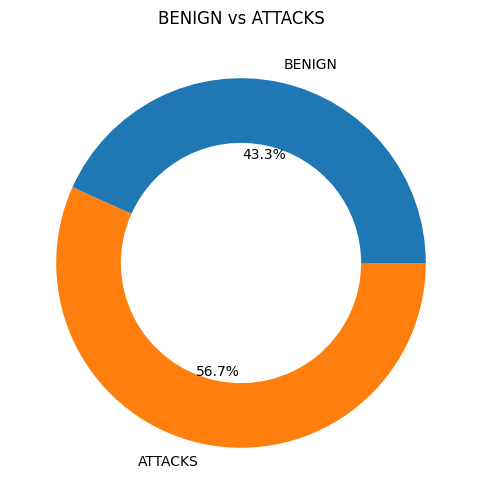

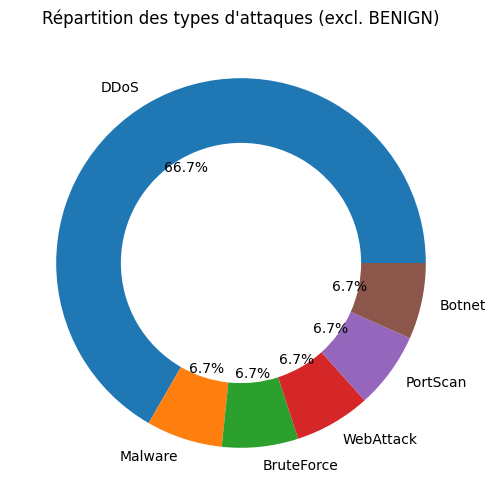

In [12]:
# Donut BENIGN vs Attacks
counts = full_df['attack_type'].value_counts()
benign_vs_attack = pd.Series({
    'BENIGN': counts.get('BENIGN', 0),
    'ATTACKS': metrics['total_attacks']
})

plt.figure(figsize=(6,6))
plt.pie(benign_vs_attack, labels=benign_vs_attack.index, autopct='%1.1f%%', wedgeprops={'width':0.35})
plt.title('BENIGN vs ATTACKS')
plt.show()

# Donut sur les types d'attaques (exclure BENIGN pour bien voir la répartition des attaques)
attacks_only = counts.drop(labels=['BENIGN'], errors='ignore')
plt.figure(figsize=(6,6))
plt.pie(attacks_only, labels=attacks_only.index, autopct='%1.1f%%', wedgeprops={'width':0.35})
plt.title('Répartition des types d\'attaques (excl. BENIGN)')
plt.show()


## Top 10 source IPs (attacks) — bar chart (dashboard-ready)

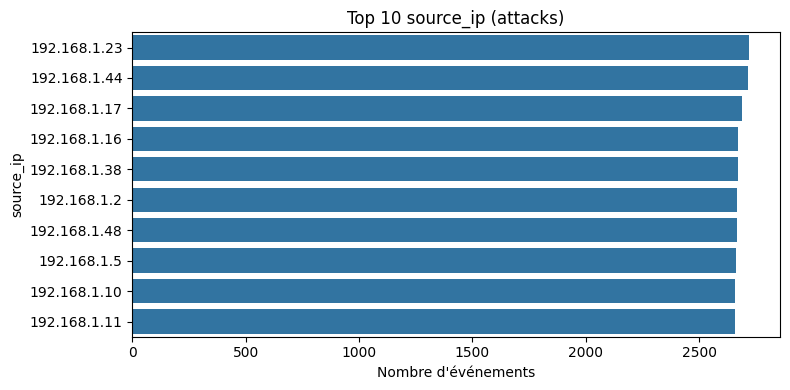

In [13]:
top_ips = full_df[full_df['attack_type'] != 'BENIGN']['source_ip'].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_ips.values, y=top_ips.index)
plt.title('Top 10 source_ip (attacks)')
plt.xlabel('Nombre d\'événements')
plt.ylabel('source_ip')
plt.tight_layout()
plt.show()


## Ports ciblés (bar chart)

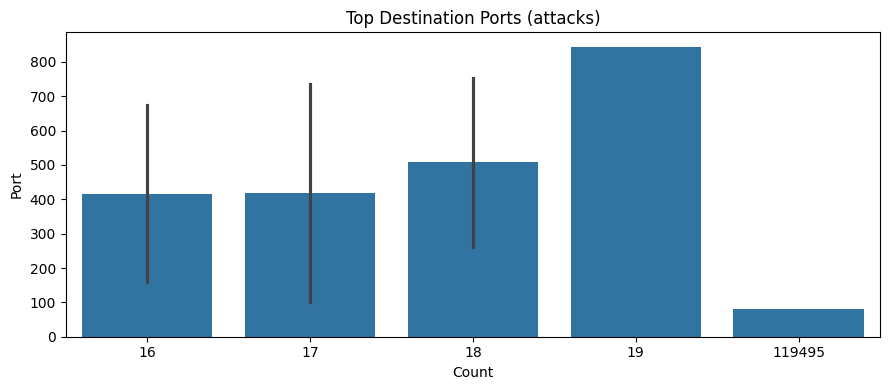

In [22]:
valid_ports = full_df[(full_df['attack_type'] != 'BENIGN') &
                      (full_df['Destination Port'].between(0, 65535))]

# Top 15 ports
ports = valid_ports['Destination Port'].value_counts().head(15)

# Graphique
plt.figure(figsize=(9,4))
sns.barplot(x=ports.values, y=ports.index)
plt.title('Top Destination Ports (attacks)')
plt.xlabel('Count')
plt.ylabel('Port')
plt.tight_layout()
plt.show()




## Timeline : attaques par minute & par heure (pour real-time)

/tmp/ipython-input-4214414588.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  attacks_per_min = df_time[df_time['attack_type'] != 'BENIGN']['is_attack'].resample('1T').sum().fillna(0)


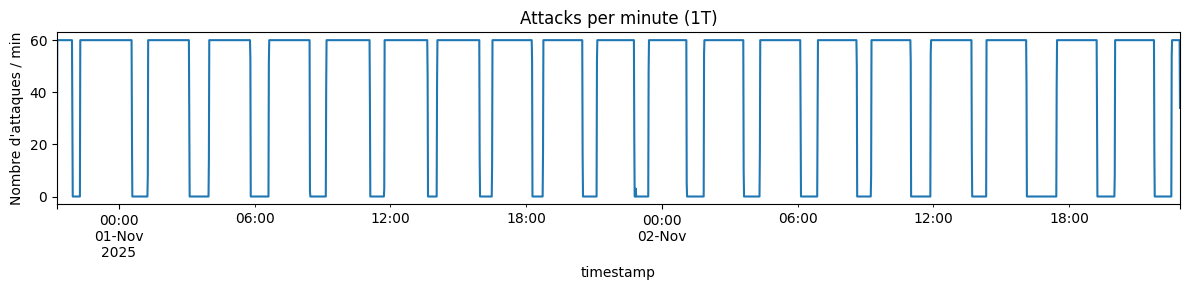

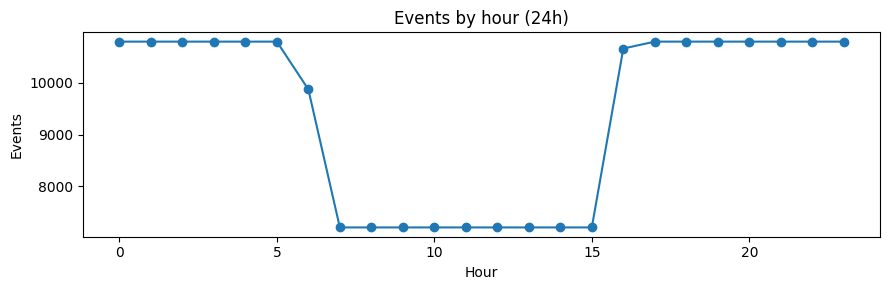

In [15]:
# Agg attacks per minute
df_time = full_df.set_index('timestamp')
attacks_per_min = df_time[df_time['attack_type'] != 'BENIGN']['is_attack'].resample('1T').sum().fillna(0)

plt.figure(figsize=(12,3))
attacks_per_min.plot()
plt.title('Attacks per minute (1T)')
plt.ylabel('Nombre d\'attaques / min')
plt.tight_layout()
plt.show()

# Activity by hour (events)
activity_by_hour = full_df.groupby('hour').size()
plt.figure(figsize=(9,3))
activity_by_hour.plot(kind='line', marker='o')
plt.title('Events by hour (24h)')
plt.xlabel('Hour')
plt.ylabel('Events')
plt.tight_layout()
plt.show()


## Heatmap jour vs heure (activité)

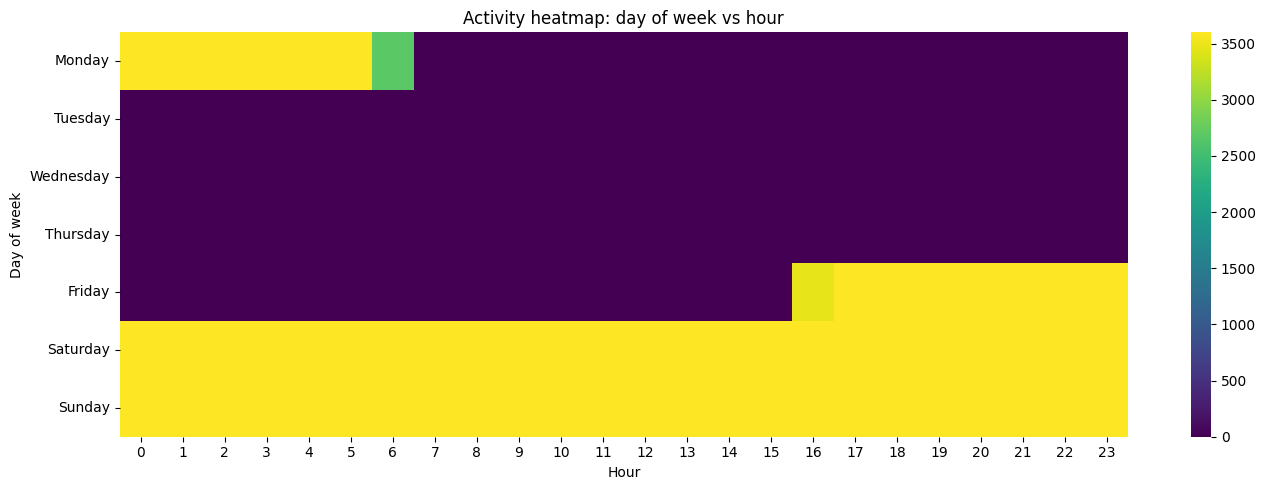

In [16]:
pivot = full_df.groupby(['dayofweek','hour']).size().unstack(fill_value=0)
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pivot = pivot.reindex(weekdays).fillna(0)

plt.figure(figsize=(14,5))
sns.heatmap(pivot, cmap='viridis')
plt.title('Activity heatmap: day of week vs hour')
plt.xlabel('Hour')
plt.ylabel('Day of week')
plt.tight_layout()
plt.show()


## Détection simple d’anomalies (IsolationForest)

In [17]:
# Petite détection d'anomalies sur des features numériques pour trouver flows suspects
from sklearn.ensemble import IsolationForest

num_cols = full_df.select_dtypes(include=[np.number]).columns.tolist()
# choisir quelques colonnes pertinentes si elles existent
candidates = [c for c in ['Flow Duration','Total Fwd Packets','Total Backward Packets','Flow Bytes/s'] if c in full_df.columns]
if candidates:
    X = full_df[candidates].fillna(0).sample(n=min(20000, len(full_df)), random_state=1)  # sample for speed
    iso = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
    preds = iso.fit_predict(X)
    # -1 = anomaly
    print("Anomalies detected:", (preds==-1).sum())
else:
    print("Pas de colonnes numériques cibles trouvées pour anomaly detection.")



Anomalies detected: 200


## Export pour Membre 3 (fichiers)

In [26]:
os.makedirs('outputs', exist_ok=True)

# metrics.csv (tableau simple)
metrics_df = pd.DataFrame([
    {'metric':'total_events','value':metrics['total_events']},
    {'metric':'total_benign','value':metrics['total_benign']},
    {'metric':'total_attacks','value':metrics['total_attacks']},
    {'metric':'attack_rate_pct','value':metrics['attack_rate_pct']}
])
metrics_df.to_csv('outputs/metrics.csv', index=False)

# stats.json (détails)
with open('outputs/stats.json','w') as f:
    json.dump(metrics, f, indent=2)

# attack_timeline.csv (timestamp, is_attack) pour real-time simulation
full_df[['timestamp','is_attack']].to_csv('outputs/attack_timeline.csv', index=False)

# top ips & ports
full_df['source_ip'].value_counts().head(500).to_csv('outputs/top_source_ips.csv', header=['count'])
if 'Destination Port' in full_df.columns:
    full_df['Destination Port'].value_counts().to_csv('outputs/top_destination_ports.csv', header=['count'])

# Save preview PNGs for dashboard
plt.figure(figsize=(8,4))
sns.countplot(data=full_df, x='attack_type', order=full_df['attack_type'].value_counts().index)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/attack_type_distribution.png')
plt.close()

plt.figure(figsize=(8,4))
sns.barplot(x=top_ips.values, y=top_ips.index)
plt.tight_layout()
plt.savefig('outputs/top_source_ips.png')
plt.close()

print("Exports written to outputs/:", os.listdir('outputs')[:20])


Exports written to outputs/: ['top_source_ips.csv', 'top_source_ips.png', 'metrics.csv', 'attack_type_distribution.png', 'top_destination_ports.csv', 'stats.json', 'attack_timeline.csv']
